<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/Causal_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dilated CNN model**



*   Prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
*   Implement a CNN model in keras to predict the next step ahead (time t+1) in the time series


*   Enable early stopping to reduce the likelihood of model overfitting
*   Evaluate the model on a test dataset

In here we are using dilated CNN model with 3 convolutional layers.

# **SETUP**

In [101]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
df = pd.read_csv(url8)

In [102]:
df=pd.DataFrame(df)
df

,Date & Time,Average Wind Speed (m/s)
0,8/1/2021,10.66
1,8/1/2021 0:10,10.71
2,8/1/2021 0:20,10.53
3,8/1/2021 0:30,10.20
4,8/1/2021 0:40,10.34
...,...,...
4404,8/31/2021 23:20,11.62
4405,8/31/2021 23:30,11.16
4406,8/31/2021 23:40,10.66
4407,8/31/2021 23:50,10.90


In [103]:
df['Date & Time'][0]="8/1/2021 0:00"
df['Date & Time'][4408]="9/1/2021  0:00"
df


,Date & Time,Average Wind Speed (m/s)
0,8/1/2021 0:00,10.66
1,8/1/2021 0:10,10.71
2,8/1/2021 0:20,10.53
3,8/1/2021 0:30,10.20
4,8/1/2021 0:40,10.34
...,...,...
4404,8/31/2021 23:20,11.62
4405,8/31/2021 23:30,11.16
4406,8/31/2021 23:40,10.66
4407,8/31/2021 23:50,10.90


In [104]:
df=df.set_index('Date & Time')
df

,Average Wind Speed (m/s)
Date & Time,
8/1/2021 0:00,10.66
8/1/2021 0:10,10.71
8/1/2021 0:20,10.53
8/1/2021 0:30,10.20
8/1/2021 0:40,10.34
...,...
8/31/2021 23:20,11.62
8/31/2021 23:30,11.16
8/31/2021 23:40,10.66


In [105]:
df.describe()

,Average Wind Speed (m/s)
count,"4,409.00"
mean,9.95
std,2.59
min,1.81
25%,8.22
50%,10.06
75%,11.88
max,16.45


**Data set plot**

In [106]:
fig = px.line(df,x=df.index, y="Average Wind Speed (m/s)") 
fig.show()

# **Train, validation and test sets**
We separate our dataset into train, validation and test sets.

*   We train the model on the train set.
*   The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data.
*   After the model has finished training, we evaluate the model on the test set.

We will allocate last 5% of the data set as test data and 5% before test data as validation data.All the other data will be training data.





In [107]:
L=len(df)
valid_start=int(18*L/20)
test_start=int(19*L/20)

train,valid,test=df[:valid_start],df[valid_start:test_start],df[test_start:L]  #seperate train and test data arrays
print(train.shape)
print(valid.shape)
print(test.shape)

print(train.describe())
print(valid.describe())
print(test.describe())

(3968, 1)
(220, 1)
(221, 1)
       Average Wind Speed (m/s)
count                  3,968.00
mean                       9.88
std                        2.65
min                        1.81
25%                        8.07
50%                       10.00
75%                       11.88
max                       15.88
       Average Wind Speed (m/s)
count                    220.00
mean                      11.35
std                        1.90
min                        6.47
25%                       10.64
50%                       11.44
75%                       12.29
max                       16.45
       Average Wind Speed (m/s)
count                    221.00
mean                       9.81
std                        1.34
min                        7.13
25%                        8.78
50%                        9.66
75%                       10.85
max                       12.50


In [108]:
train

,Average Wind Speed (m/s)
Date & Time,
8/1/2021 0:00,10.66
8/1/2021 0:10,10.71
8/1/2021 0:20,10.53
8/1/2021 0:30,10.20
8/1/2021 0:40,10.34
...,...
8/28/2021 21:50,14.26
8/28/2021 22:00,14.00
8/28/2021 22:10,13.36


In [109]:
#date_time = pd.to_datetime(df_new['Date & Time'], format='%m/%d/%Y %H:%M')

# **Data preparation - training data**

I will get the input for each sample is a vector of previous **T lagged values**

**HORIZON=1** specifies that we have a forecasting horizon of 1 (t+1)

In [110]:
T = 10
HORIZON = 1

**Scale the time series within [0,1]**

In [111]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train=pd.DataFrame(train["Average Wind Speed (m/s)"])
train["Average Wind Speed (m/s)"] = scaler.fit_transform(train)
train.head(10)

,Average Wind Speed (m/s)
Date & Time,
8/1/2021 0:00,0.63
8/1/2021 0:10,0.63
8/1/2021 0:20,0.62
8/1/2021 0:30,0.60
8/1/2021 0:40,0.61
8/1/2021 0:50,0.62
8/1/2021 1:00,0.63
8/1/2021 1:10,0.65
8/1/2021 1:20,0.64



**Original vs scaled data:**

In [112]:
'''df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":'original wind speed'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={"Average Wind Speed (m/s)":'scaled wind speed'}).plot.hist(bins=100, fontsize=12)
plt.show()'''

'df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":\'original wind speed\'}).plot.hist(bins=100, fontsize=12)\ntrain.rename(columns={"Average Wind Speed (m/s)":\'scaled wind speed\'}).plot.hist(bins=100, fontsize=12)\nplt.show()'

**Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example**

In [113]:
train_shifted = train.copy()
for i in range (1,HORIZON+1):
  train_shifted['y_t+'+str(i)] = train_shifted["Average Wind Speed (m/s)"].shift(-i)
train_shifted.head(10)

,Average Wind Speed (m/s),y_t+1
Date & Time,,
8/1/2021 0:00,0.63,0.63
8/1/2021 0:10,0.63,0.62
8/1/2021 0:20,0.62,0.60
8/1/2021 0:30,0.60,0.61
8/1/2021 0:40,0.61,0.62
8/1/2021 0:50,0.62,0.63
8/1/2021 1:00,0.63,0.65
8/1/2021 1:10,0.65,0.64
8/1/2021 1:20,0.64,0.63


**Get T no of lagged values**

In [114]:
for t in range(1, T+1):
    train_shifted['wind_speed_t-'+str(T-t)] = train_shifted["Average Wind Speed (m/s)"].shift(T-t)
train_shifted = train_shifted.rename(columns={"Average Wind Speed (m/s)":'Original_wind_speed'})
train_shifted.head(10)

,Original_wind_speed,y_t+1,wind_speed_t-9,wind_speed_t-8,wind_speed_t-7,wind_speed_t-6,wind_speed_t-5,wind_speed_t-4,wind_speed_t-3,wind_speed_t-2,wind_speed_t-1,wind_speed_t-0
Date & Time,,,,,,,,,,,,
8/1/2021 0:00,0.63,0.63,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.63
8/1/2021 0:10,0.63,0.62,nan,nan,nan,nan,nan,nan,nan,nan,0.63,0.63
8/1/2021 0:20,0.62,0.60,nan,nan,nan,nan,nan,nan,nan,0.63,0.63,0.62
8/1/2021 0:30,0.60,0.61,nan,nan,nan,nan,nan,nan,0.63,0.63,0.62,0.60
8/1/2021 0:40,0.61,0.62,nan,nan,nan,nan,nan,0.63,0.63,0.62,0.60,0.61
8/1/2021 0:50,0.62,0.63,nan,nan,nan,nan,0.63,0.63,0.62,0.60,0.61,0.62
8/1/2021 1:00,0.63,0.65,nan,nan,nan,0.63,0.63,0.62,0.60,0.61,0.62,0.63
8/1/2021 1:10,0.65,0.64,nan,nan,0.63,0.63,0.62,0.60,0.61,0.62,0.63,0.65
8/1/2021 1:20,0.64,0.63,nan,0.63,0.63,0.62,0.60,0.61,0.62,0.63,0.65,0.64


In [115]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,Original_wind_speed,y_t+1,wind_speed_t-9,wind_speed_t-8,wind_speed_t-7,wind_speed_t-6,wind_speed_t-5,wind_speed_t-4,wind_speed_t-3,wind_speed_t-2,wind_speed_t-1,wind_speed_t-0
Date & Time,,,,,,,,,,,,
8/1/2021 1:30,0.63,0.63,0.63,0.63,0.62,0.60,0.61,0.62,0.63,0.65,0.64,0.63
8/1/2021 1:40,0.63,0.64,0.63,0.62,0.60,0.61,0.62,0.63,0.65,0.64,0.63,0.63
8/1/2021 1:50,0.64,0.65,0.62,0.60,0.61,0.62,0.63,0.65,0.64,0.63,0.63,0.64
8/1/2021 2:00,0.65,0.68,0.60,0.61,0.62,0.63,0.65,0.64,0.63,0.63,0.64,0.65
8/1/2021 2:10,0.68,0.69,0.61,0.62,0.63,0.65,0.64,0.63,0.63,0.64,0.65,0.68


**Convert the target variable into a numpy array(vector format)**

In [116]:
y_train = np.array(train_shifted[["y_t+1"]])

In [117]:
y_train.shape

(3958, 1)

In [118]:
y_train

array([[0.63],
       [0.64],
       [0.65],
       ...,
       [0.82],
       [0.77],
       [0.76]])

**Convert the inputs into a numpy array with shape (samples, time steps, features)**

In [119]:
X_train=np.array(train_shifted[['wind_speed_t-'+str(T-t) for t in range(1, T+1)]])
X_train = X_train[... , np.newaxis]


In [120]:
X_train.shape

(3958, 10, 1)

In [121]:
X_train[1]

array([[0.63],
       [0.62],
       [0.6 ],
       [0.61],
       [0.62],
       [0.63],
       [0.65],
       [0.64],
       [0.63],
       [0.63]])

# **Data preparation - validation set**

In [122]:
valid=pd.DataFrame(valid["Average Wind Speed (m/s)"])
valid

,Average Wind Speed (m/s)
Date & Time,
8/28/2021 22:40,12.22
8/28/2021 22:50,12.48
8/28/2021 23:00,12.25
8/28/2021 23:10,11.99
8/28/2021 23:20,11.89
...,...
8/30/2021 10:30,8.22
8/30/2021 10:40,8.23
8/30/2021 10:50,8.03


In [123]:
valid_new=df[valid_start-T+1:test_start]
valid_new=pd.DataFrame(valid_new["Average Wind Speed (m/s)"])
valid_new.head(20)

,Average Wind Speed (m/s)
Date & Time,
8/28/2021 21:10,14.16
8/28/2021 21:20,14.37
8/28/2021 21:30,14.50
8/28/2021 21:40,14.74
8/28/2021 21:50,14.26
8/28/2021 22:00,14.00
8/28/2021 22:10,13.36
8/28/2021 22:20,12.71
8/28/2021 22:30,12.51


In [124]:
valid_new['Average Wind Speed (m/s)']=scaler.transform(valid_new)
valid_new.head()

,Average Wind Speed (m/s)
Date & Time,
8/28/2021 21:10,0.88
8/28/2021 21:20,0.89
8/28/2021 21:30,0.90
8/28/2021 21:40,0.92
8/28/2021 21:50,0.88


In [125]:
valid_shifted = valid_new.copy()
valid_shifted['y_t+1'] = valid_shifted["Average Wind Speed (m/s)"].shift(-HORIZON)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['wind_speed_t-'+str(T-t)] = valid_shifted["Average Wind Speed (m/s)"].shift(T-t)
vali_shifted = valid_shifted.rename(columns={"Average Wind Speed (m/s)":'Original_wind_speed'})

valid_shifted = valid_shifted.dropna(how='any')
y_valid = np.array(valid_shifted[["y_t+1"]])
X_valid=np.array(valid_shifted[['wind_speed_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid[... , np.newaxis]

In [126]:
y_valid.shape

(219, 1)

In [127]:
X_valid.shape

(219, 10, 1)

# **Implement the Convolutional Neural Network**
We implement the convolutional neural network with 3 layers, 10 neurons in each layer, a kernel size of 2 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

In [128]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

**MODEL PARAMETERS**

In [129]:
#LATENT_DIM = 10 # number of units in the RNN layer
KERNEL_SIZE = 2 # Kernel size
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 50 # maximum number of times the training algorithm will cycle through all samples

In [130]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=KERNEL_SIZE,activation='relu', input_shape=(T, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))


In [131]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 25,993
Trainable params: 25,993
Non-trainable params: 0
_________________________________________________________________


Use Adam optimizer and mean squared error as the loss function.

In [132]:
model.compile(optimizer='Adam', loss='mse')

In [133]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [134]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [135]:
history = model.fit(X_train,
          y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/50
124/124 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0044
Epoch 2/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 3/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 4/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 5/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 6/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 7/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 8/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 9/50
124/124 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0025


Load the model with the smallest mape

In [136]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

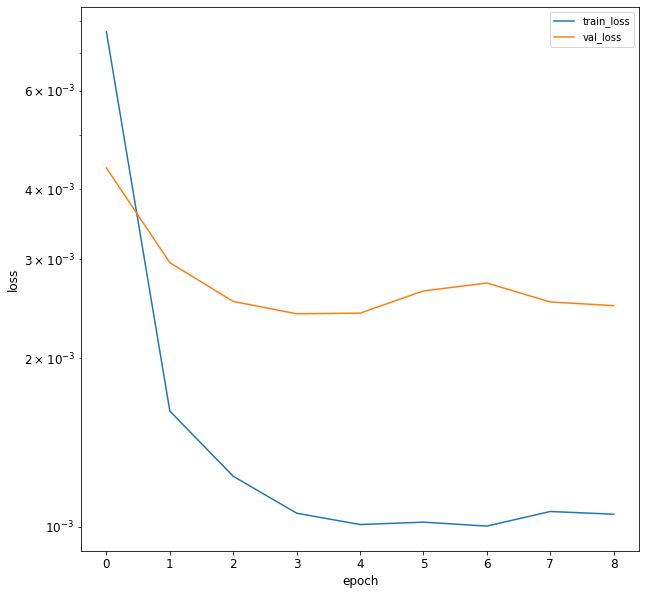

In [137]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# **Evaluate the model** 

**Create the test set**

In [138]:
test=pd.DataFrame(test["Average Wind Speed (m/s)"])
test

,Average Wind Speed (m/s)
Date & Time,
8/30/2021 11:20,8.55
8/30/2021 11:30,8.59
8/30/2021 11:40,8.64
8/30/2021 11:50,8.67
8/30/2021 12:00,8.53
...,...
8/31/2021 23:20,11.62
8/31/2021 23:30,11.16
8/31/2021 23:40,10.66


In [139]:
test_new=df[test_start-T+1:L]
test_new=pd.DataFrame(test_new["Average Wind Speed (m/s)"])
test_new.head(20)

,Average Wind Speed (m/s)
Date & Time,
8/30/2021 9:50,7.62
8/30/2021 10:00,7.68
8/30/2021 10:10,8.08
8/30/2021 10:20,8.39
8/30/2021 10:30,8.22
8/30/2021 10:40,8.23
8/30/2021 10:50,8.03
8/30/2021 11:00,8.17
8/30/2021 11:10,8.13


**Scale tht test data**

In [140]:
test_new['Average Wind Speed (m/s)']=scaler.transform(test_new)
test_new.head()

,Average Wind Speed (m/s)
Date & Time,
8/30/2021 9:50,0.41
8/30/2021 10:00,0.42
8/30/2021 10:10,0.45
8/30/2021 10:20,0.47
8/30/2021 10:30,0.46


**Create test set features**

In [141]:
test_shifted = test_new.copy()
test_shifted['y_t+1'] = test_shifted["Average Wind Speed (m/s)"].shift(-HORIZON)
print(test_shifted)

for t in range(1, T+1):
    test_shifted['wind_speed_t-'+str(T-t)] = test_shifted["Average Wind Speed (m/s)"].shift(T-t)
test_shifted = test_shifted.rename(columns={"Average Wind Speed (m/s)":'Original_wind_speed'})

test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted[["y_t+1"]])
X_test=np.array(test_shifted[['wind_speed_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test[... , np.newaxis]

                 Average Wind Speed (m/s)  y_t+1
Date & Time                                     
8/30/2021 9:50                       0.41   0.42
8/30/2021 10:00                      0.42   0.45
8/30/2021 10:10                      0.45   0.47
8/30/2021 10:20                      0.47   0.46
8/30/2021 10:30                      0.46   0.46
...                                   ...    ...
8/31/2021 23:20                      0.70   0.66
8/31/2021 23:30                      0.66   0.63
8/31/2021 23:40                      0.63   0.65
8/31/2021 23:50                      0.65   0.65
9/1/2021  0:00                       0.65    nan

[230 rows x 2 columns]


**Make predictions on test set**

In [142]:
predictions = model.predict(X_test)
predictions

array([[0.44],
       [0.46],
       [0.48],
       [0.48],
       [0.48],
       [0.47],
       [0.48],
       [0.5 ],
       [0.48],
       [0.47],
       [0.45],
       [0.43],
       [0.43],
       [0.42],
       [0.46],
       [0.49],
       [0.52],
       [0.58],
       [0.63],
       [0.61],
       [0.6 ],
       [0.59],
       [0.56],
       [0.53],
       [0.52],
       [0.5 ],
       [0.51],
       [0.55],
       [0.56],
       [0.58],
       [0.59],
       [0.57],
       [0.55],
       [0.57],
       [0.64],
       [0.65],
       [0.65],
       [0.66],
       [0.64],
       [0.62],
       [0.64],
       [0.67],
       [0.64],
       [0.62],
       [0.61],
       [0.59],
       [0.59],
       [0.62],
       [0.65],
       [0.67],
       [0.66],
       [0.64],
       [0.63],
       [0.62],
       [0.6 ],
       [0.61],
       [0.6 ],
       [0.6 ],
       [0.59],
       [0.57],
       [0.55],
       [0.53],
       [0.49],
       [0.46],
       [0.47],
       [0.46],
       [0.

In [143]:
predictions=pd.DataFrame(predictions)
predictions

,0
0,0.44
1,0.46
2,0.48
3,0.48
4,0.48
...,...
215,0.72
216,0.71
217,0.69
218,0.66


**Compare predictions to actual wind speed**

In [144]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 
eval_df

#eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
#eval_df

,timestamp,h,prediction,actual
0,8/30/2021 11:20,t+1,0.44,0.48
1,8/30/2021 11:30,t+1,0.46,0.49
2,8/30/2021 11:40,t+1,0.48,0.49
3,8/30/2021 11:50,t+1,0.48,0.48
4,8/30/2021 12:00,t+1,0.48,0.50
...,...,...,...,...
215,8/31/2021 23:10,t+1,0.72,0.70
216,8/31/2021 23:20,t+1,0.71,0.66
217,8/31/2021 23:30,t+1,0.69,0.63
218,8/31/2021 23:40,t+1,0.66,0.65


In [145]:
eval_df[['prediction']]=scaler.inverse_transform(np.array(eval_df[['prediction']]))
eval_df[['actual']]=scaler.inverse_transform(np.array(eval_df[['actual']]))
#eval_df[['prediction']].shape
eval_df

,timestamp,h,prediction,actual
0,8/30/2021 11:20,t+1,8.05,8.59
1,8/30/2021 11:30,t+1,8.33,8.64
2,8/30/2021 11:40,t+1,8.58,8.67
3,8/30/2021 11:50,t+1,8.52,8.53
4,8/30/2021 12:00,t+1,8.59,8.80
...,...,...,...,...
215,8/31/2021 23:10,t+1,11.92,11.62
216,8/31/2021 23:20,t+1,11.80,11.16
217,8/31/2021 23:30,t+1,11.58,10.66
218,8/31/2021 23:40,t+1,11.11,10.90


In [146]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

3.5665526189150034

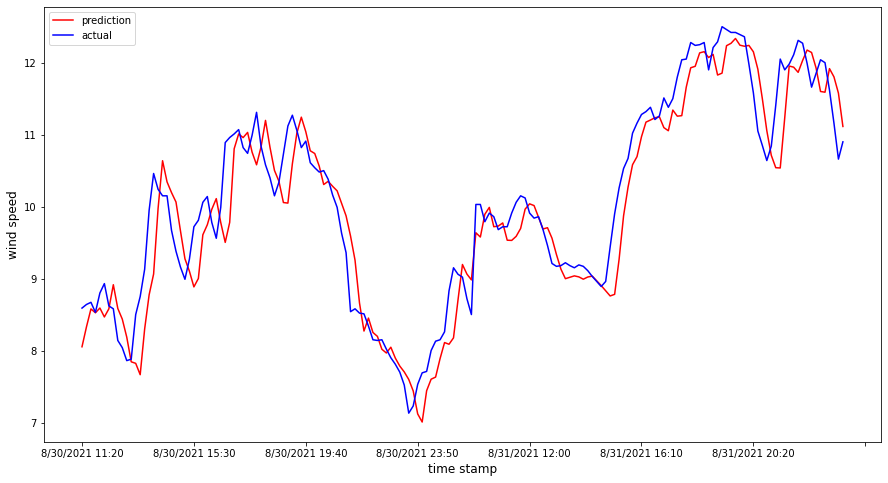

In [147]:
eval_df[eval_df.timestamp<'8/31/2021 23:50'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('time stamp', fontsize=12)
plt.ylabel('wind speed', fontsize=12)
plt.show()

**Clean up model files**

In [148]:
for m in glob('model_*.h5'):
    os.remove(m)